# Demonstration: Cohesive Energy vs. Interatomic Spacing

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-03-30

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

- - -

## Software

This Notebook was tested with:

- LAMMPS (Version 2016-03-11)

- Python (Version 2.7.11)

- IPython (Version 4.0.3)

- - -

## Introduction

This Notebook plots the cohesive energy vs. nearest neighbor atomic spacings for a list of orthorhombic crystal prototypes.  

__NOTE:__ For this calculation, no atomic relaxations are performed and the ideal b/a and c/a ratios are retained. 

- - -

## 1. Initial Setup

1. __Necessary Python Libraries__: This is a list of the Python libraries used to run this code. 

2. __Necessary Parameters__: These are the parameters that need to be specified to run the code.

3. __Calculation Parameters__: These are user-specified parameters that control how the calculation proceeds, such as number of data points.

### 1.1 Necessary Python Libraries

This is a list of the Python libraries used to run this code.

- [numpy](http://www.numpy.org/) (Version 1.10.04)

- [matplotlib](http://matplotlib.org/) (Version 1.5.1)

- [atomman](https://github.com/usnistgov/atomman) (Version 0.6)

- [DataModelDict](https://github.com/usnistgov/DataModelDict) (Version 0.8)

In [1]:
#Standard Python Libraries
import subprocess
import os
from collections import OrderedDict
import sys

#Additional Python Libraries
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import atomman as am
import atomman.unitconvert as uc
import atomman.lammps as lmp
from DataModelDict import DataModelDict

### 1.2 Necessary Parameters

These are the parameters that need to be specified to run the code.

- __lammps_exe__ = the directory location for the LAMMPS executable to use.

- __working_dir__ = the working directory where you want this Notebook to run.

- __potential_file__ = the name (and location) of the interatomic potential data model file associated with the potential you want to use.

- __potential_dir__ = the directory location where any potential artifacts (i.e. eam setfl, meam library files) are located.

- __prototype_file__ = the data model file associated with the crystal prototype to generate. 

In [2]:
#Specify paths to necessary files and directories
lammps_exe = 'C:\\users\\lmh1\\Documents\\lmp_serial.exe'
 
working_dir = 'calc_structure_static'

#This prevents recursive directories upon re-running this cell
if os.path.basename(os.getcwd()) == working_dir:
    working_dir = os.getcwd()
else:
    working_dir = os.path.realpath(working_dir)
    
#2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json is created in section 2.2
potential_file = os.path.join(working_dir, '2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json')

#MEAM library and potential files for 2012--Jelinek-B--Al-Si-Mg-Cu-Fe
#potential are created in section 2.1
potential_dir = working_dir

#A1--Cu--fcc.json is created in section 2.3
prototype_file = os.path.join(working_dir, 'A1--Cu--fcc.json')

#move to working_dir
try:
    os.chdir(working_dir)
except:
    os.makedirs(working_dir)
    os.chdir(working_dir)

### 1.3 Calculation Parameters

These are user-specified parameters that control how the calculation proceeds, such as number of data points.

- __r_min__ = minimum interatomic spacing, _r_.

- __r_max__ = maximum interatomic spacing, _r_.

- __steps__ = number of values to evaluate from r_min to r_max.

In [3]:
#Set range of r values to use
r_min = 2.0
r_max = 5.0
steps = 200

## 2. Additional Data Files

To make this notebook self-contained, we have embedded a few files.

1. __MEAM Potential.__ Generates library and parameter files for one MEAM potential.

2. __Potential Data Model.__ Collects all input parameters assoiciated with running the MEAM potential in LAMMPS.

3. __Prototype Data Model.__ Generates an instance of the crystal prototype data model used to generate various structures.

### 2.1 MEAM Potential

This generates the library and parameter files associated with the following interatomic potential taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

__2012--Jelinek-B--Al-Si-Mg-Cu-Fe__

__Aluminum, Silicon, Magnesium, Copper, and Iron (Al, Si, Mg, Cu, and Fe) Alloys__

*B. Jelinek, S. Groh, M. Horstemeyer, J. Houze, S.G. Kim, G.J. Wagner, A. Moitra, and M.I. Baskes, "Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys," Phys. Rev. B 85, 245102 (2012).*

__Notes__: This file was provided by Bohumir Jelinek (Mississippi State University) and posted on 3 July 2012. He noted, "This is a MEAM potential for Al, Si, Mg, Cu, Fe alloys. It works with LAMMPS, version 19 Jul 2011 or later, when compiled with MEAM support."

__Notice__: Users should consider all available potentials and select one which is appropriate for their use case. Use of this potential within this demonstration should not be construed as an endorsement or a recommendation. 

In [4]:
#Create MEAM library and parameter files for the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential
   
#Create MEAM library file "Jelinek_2012_meamf"
f = open('Jelinek_2012_meamf', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
f.close()

#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
f = open('Jelinek_2012_meam.alsimgcufe', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")
f.close()

### 2.2 Potential Data Model

This generates the interatomic potential data model file associated with the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential.

In [5]:
#Creates a interatomic potential data model for using the MEAM potential in LAMMPS
f = open('2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json', 'w')
f.write("""{
    "LAMMPS-potential": {
        "potential": {
            "key": "1515dd80-1984-49de-bc92-d5724059ff56", 
            "id": "2012--Jelinek-B--Al-Si-Mg-Cu-Fe"
        }, 
        "units": "metal", 
        "atom_style": "atomic", 
        "atom": [
            {
                "symbol": "AlS",
                "element": "Al", 
                "mass": 26.9815                
            }, 
            {
                "symbol": "SiS",
                "element": "Si", 
                "mass": 28.086                
            }, 
            {
                "symbol": "MgS", 
                "element": "Mg",
                "mass": 24.305                
            }, 
            {
                "symbol": "CuS", 
                "element": "Cu", 
                "mass": 63.54
            }, 
            {
                "symbol": "FeS", 
                "element": "Fe", 
                "mass": 55.847
            }
        ], 
        "pair_style": {
            "type": "meam"
        }, 
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                }, 
                {
                    "symbolsList": "True"
                }, 
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                }, 
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")
f.close()    

### 2.3 Prototype Data Model

This generates the crystal prototype data model file associated with the fcc crystal prototype.

In [6]:
#Creates an instance of a crystal prototype data model for generating crystal structures.
f = open('A1--Cu--fcc.json', 'w')
f.write("""{
    "crystal-prototype": {
        "identifier": {
            "common": "face-centered cubic", 
            "tag": "fcc", 
            "prototype": "Cu", 
            "Pearson-symbol": "cF4", 
            "Strukturbericht": "A1"
        }, 
        "space-group": {
            "number": 225, 
            "Hermann-Maguin": "F m -3 m", 
            "Schoenflies": "O^5_h", 
            "Wykoff": {
                "letter": "a", 
                "multiplicity": 4
            }
        }, 
        "atomic-system": {
            "cell": {
                "cubic": {
                    "a": {
                        "value": 1.0, 
                        "unit": "scaled"
                    }
                }
            }, 
            "atom": [
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.0, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.5, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.0, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.5, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }
            ]
        }
    }
}""")
f.close()

## 3. LAMMPS Script Generation Function(s)

This code generates the underlying LAMMPS script(s) for performing the necessary simulations. For all scripts, system_info and pair_info are required.  system_info is the LAMMPS script lines associated with either generating or reading in atomic system information.  pair_info is the LAMMPS script lines that assigns the atomic interaction model information.  

- __alat_script()__ hydrostatically strains a systen over an entire strain range given by delta, and number of data points given by steps. The energy of each strain state is calculated without relaxation using run 0.  

In [7]:
def alat_script(system_info, pair_info, delta = 1e-5, steps = 2):
    """
    Create a LAMMPS script that applies a hydrostatic strain.
    
    Keyword Arguments:
    system_info -- string containing LAMMPS commands for creating/reading a system.
    pair_info -- string containing LAMMPS commands specific to the interatomic potential.
    delta -- float value indicating strain range. Default is 1e-5.
    steps -- integer number of strain steps. Defaut is 2.    
    """
    nl = '\n'
    script = nl.join([system_info,
                      '',
                      pair_info,
                      '',
                      'variable lx0 equal lx',
                      'variable ly0 equal ly',
                      'variable lz0 equal lz',
                      '',
                      'variable deltax equal %f/%f' % (delta, steps-1),
                      'variable aratio equal 1-%f/2.+(v_a-1)*${deltax}' % (delta),
                      '',
                      'variable xmax equal v_aratio*${lx0}',
                      'variable ymax equal v_aratio*${ly0}',
                      'variable zmax equal v_aratio*${lz0}',
                      '',
                      'variable peatom equal pe/atoms',
                      'thermo_style custom step lx ly lz pxx pyy pzz v_peatom pe',
                      'thermo_modify format float %.13e',
                      '',
                      'label loop',
                      '',
                      'variable a loop %i' % (steps),
                      'change_box all x final 0 ${xmax} y final 0 ${ymax} z final 0 ${zmax} remap units box',
                      'run 0',
                      'next a','jump alat.in loop'])
    return script            

## 4. Python Calculation Function(s)

These functions are associated with setting up the atomic systems, running LAMMPS, extracting the simulation data, and refining the results.

- __ecoh_vs_r()__ sets up and runs LAMMPS using the script generated from alat_script(). Returns lists of the lattice parameters, _a_, nearest neighbor distances, _r_, and the calculated cohesive energies, _E_.

- __iterbox()__ allows for dynamic iteration over all arrays of length b where each term is in the range 0-a. This is used here for investigations over multiple elements and crystal prototypes with multiple unique sites.

- __r_a_ratio()__ identifies the shortest nearest neighbor distance for a system and returns it relative to the _a_ lattice parameter.


In [8]:
def ecoh_vs_r(lammps_exe, prototype, potential, symbols, rmin=2.0, rmax=5.0, rsteps=200):
    """Measure cohesive energy of a crystal prototype as a function of nearest neighbor distance, r0"""
    ucell = am.models.crystal(prototype)[0]
    
    #Initial size setup
    r_a = r_a_ratio(ucell)
    amin = rmin / r_a
    amax = rmax / r_a
    alat0 = (amax + amin) / 2.
    delta = (amax-amin)/alat0
    
    #Create unit cell with a = alat0
    ucell.box_set(a = alat0, b = alat0 * ucell.box.b, c = alat0 * ucell.box.c, scale=True)
    
    #LAMMPS script setup
    pair_info = potential.pair_info(symbols)
    
    system_info = lmp.sys_gen(units =       potential.units,
                              atom_style =  potential.atom_style,
                              ucell =       ucell,
                              size =        np.array([[0,3], [0,3], [0,3]], dtype=np.int))

    #Write the LAMMPS input file
    with open('alat.in','w') as script:
        script.write(alat_script(system_info, pair_info, delta=delta, steps=rsteps))
    
    #Run LAMMPS
    data = lmp.run(lammps_exe, 'alat.in')
 
    #extract thermo data from log output 
    avalues = np.array(data.finds('Lx')) / 3.
    rvalues = avalues * r_a
    evalues = np.array(data.finds('peatom'))  
        
    #Use potential units and atom_style terms to convert values to appropriate length and energy units
    lmp_units = lmp.style.unit(potential.units)
    avalues = uc.set_in_units(avalues, lmp_units['length'])
    rvalues = uc.set_in_units(rvalues, lmp_units['length'])
    evalues = uc.set_in_units(evalues, lmp_units['energy'])
        
    return rvalues, avalues, evalues    

def iterbox(a, b):
    """Iterates over all arrays of length b where each term independently ranges 0:a."""
    for i in xrange(a):    
        if b > 1:
            for j in iterbox(a,b-1):
                yield [i] + j    
        elif b == 1:
            yield [i] 
            
            
def r_a_ratio(ucell):
    """Calculates the shortest interatomic spacing, r, for a system wrt to box.a."""
    r_a = ucell.box.a
    for i in xrange(ucell.natoms):
        for j in xrange(i):
            dmag = np.linalg.norm(ucell.dvect(i,j))
            if dmag < r_a:
                r_a = dmag
    return r_a/ucell.box.a
            

## 5. Run Calculation and Display Results

This is the code that runs the calculation function(s) for the supplied inputs and displays the resulting data.

In [9]:
#Read the interatomic potential data model file
with open(potential_file) as f:
    potential = lmp.Potential(f, potential_dir)
all_symbols = potential.symbols

#read prototype file
with open(prototype_file) as f:
    prototype = DataModelDict(f).find('crystal-prototype')
ucell = am.models.crystal(prototype)[0]
    
#Create dictionary for storing results
results = DataModelDict()
    
#Iterate over all possible element-site combinations for the potential and crystal prototype
for el_array in iterbox(len(all_symbols), ucell.natypes):
    
    #Build symbols list for the particular iteration
    symbols = []
    for el_index in el_array:
        symbols.append(all_symbols[el_index])

    #Compose structure name by combining crystal prototype and composition
    elements = potential.elements(symbols)
    structure = prototype.find('tag')
    for i in xrange(len(elements)):
        structure += ' ' + elements[i]
        
    #Run calculation function
    rvals, avals, evals = ecoh_vs_r(lammps_exe, prototype, potential, symbols, rmin=r_min, rmax=r_max, rsteps=steps)
    
    #Save values to results
    results[structure] = DataModelDict()
    results[structure]['rvals'] = rvals
    results[structure]['avals'] = avals
    results[structure]['evals'] = evals

Plot _E<sub>coh</sub>_ vs. _r_

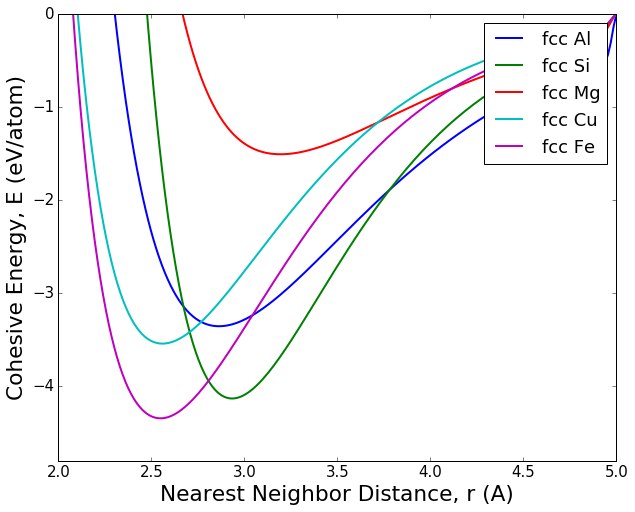

In [10]:
#Initial plot setup
matplotlib.rc('lines',lw=2)
matplotlib.rc('font',size=15)
plt.figure(figsize=(10,8))

minE = 0.

for structure, values in results.iteritems():
    
    #Convert to angstom and eV
    rvals = uc.get_in_units(values['rvals'], 'angstrom')
    evals = uc.get_in_units(values['evals'], 'eV')

    #Plot data
    plt.plot(rvals, evals, label=structure, lw=2)   
    if min(evals) < minE:
        minE = min(evals)
        
#Final plot setup and show
plt.legend(loc='upper right')
plt.xlabel('Nearest Neighbor Distance, r (A)', size='x-large')
plt.ylabel('Cohesive Energy, E (eV/atom)', size='x-large')
plt.ylim(round(minE, 1)-.5,0.0)
plt.xlim(r_min, r_max)
plt.show()

Get rough lattice parameter, _a_<sub>0</sub>, guesses from plot

In [11]:
print 'Rough lattice parameter, a0, and cohesive energy, Ecoh, guesses:'
print
for structure, values in results.iteritems():
    
    #Convert to angstom and eV
    rvals = uc.get_in_units(values['rvals'], 'angstrom')
    evals = uc.get_in_units(values['evals'], 'eV')
    
    #Identify lattice parameter for smallest cohesive energy measured in the plot range (NOT REFINED!)
    mindex = np.argmin(evals)
    print '%s:' % structure
    print '    a0 =   %.3f (A)' % avals[mindex]
    print '    Ecoh = %.2f (eV/atom)' % evals[mindex]
    print

Rough lattice parameter, a0, and cohesive energy, Ecoh, guesses:

fcc Al:
    a0 =   4.044 (A)
    Ecoh = -3.35 (eV/atom)

fcc Si:
    a0 =   4.150 (A)
    Ecoh = -4.13 (eV/atom)

fcc Mg:
    a0 =   4.513 (A)
    Ecoh = -1.50 (eV/atom)

fcc Cu:
    a0 =   3.617 (A)
    Ecoh = -3.54 (eV/atom)

fcc Fe:
    a0 =   3.596 (A)
    Ecoh = -4.34 (eV/atom)

